# Proyecto final

# *Telecomunicacones: identificar operadores ineficaces* 

## Link de Drive: https://drive.google.com/drive/folders/1yOHUD-V54aoaNC7aD7akkukaLQIgnEJe?hl=es

El objetivo de este análisis es identificar operadores ineficaces dentro del servicio de telefonía virtual **CallMeMaybe**. Un operador se considera ineficaz si:

- Tiene una gran cantidad de llamadas entrantes perdidas.
- Presenta un tiempo de espera prolongado en llamadas entrantes.
- Si realiza llamadas salientes, tiene un número reducido de ellas.

In [346]:
#Cargamos las librerías y los datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import shapiro, levene
from scipy.stats import f_oneway
from scipy.stats import kruskal

calls = pd.read_csv("telecom_dataset_us.csv")
clients = pd.read_csv("telecom_clients_us.csv")

In [347]:
# Mostramos la información básica del dataset calls
calls.info()
calls.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
46269,168091,2019-11-21 00:00:00+03:00,out,True,958460.0,True,1,0,36
7233,166582,2019-10-23 00:00:00+03:00,in,False,885876.0,False,16,934,1078
32071,167445,2019-11-26 00:00:00+03:00,out,False,943066.0,True,2,0,15
48957,168187,2019-11-19 00:00:00+03:00,out,False,937854.0,True,8,0,299
4956,166511,2019-10-31 00:00:00+03:00,in,False,891416.0,False,3,921,963


In [348]:
# Mostramos la información básica del dataset clients
clients.info()
clients.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


,user_id,tariff_plan,date_start
320,167019,C,2019-08-28
485,167929,B,2019-10-07
490,166678,B,2019-08-14
10,168573,A,2019-10-31
696,168245,B,2019-10-17


**Preprocesamiento de los datos**

In [349]:
# Revisamos si hay valores faltantes
print(calls.isnull().sum())
print(clients.isnull().sum())


user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64
user_id        0
tariff_plan    0
date_start     0
dtype: int64


Se encontraron valores nulos en `internal` y en `operator_id`. En el caso de la columna `internal` solo indica si una llamada fue interna, por lo que solo puede tener 2 posibles valores, así que para lidiar con dichos valores faltantes debemos verificar que porcentaje representan:

In [350]:
print(f"Porcentaje de valores nulos en 'internal': {calls['internal'].isnull().mean() * 100:.2f}%")


Porcentaje de valores nulos en 'internal': 0.22%


Al ser tan pequeño el porcentaje se decidio rellenar los valores nulos con `False`:

In [351]:
calls["internal"].fillna(False, inplace=True)


C:\Users\Mares\AppData\Local\Temp\ipykernel_4560\3311006510.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  calls["internal"].fillna(False, inplace=True)
C:\Users\Mares\AppData\Local\Temp\ipykernel_4560\3311006510.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  calls["internal"].fillna(False, inplace=Tr


Por el otro lado, en el caso de `operator_id` estos valores ausentes podrían significar que la llamada no estuvo asociada con ningún operador específico. Vamos a verificar que porcentaje representan:

In [352]:
print(f"Porcentaje de valores nulos en 'operator_id': {calls['operator_id'].isnull().mean() * 100:.2f}%")


Porcentaje de valores nulos en 'operator_id': 15.16%


In [353]:
print(calls[calls["operator_id"].isnull()]["direction"].value_counts())
print(calls[calls["operator_id"].isnull()]["is_missed_call"].value_counts())


direction
in     7972
out     200
Name: count, dtype: int64
is_missed_call
True     8050
False     122
Name: count, dtype: int64


Vemos que gran parte de estos valores nulos corresponden a llamadas entrantes y la gran mayoría fueron llamadas perdidas, lo que sugiere que las llamadas entrantes perdidas no se asignaron a ningún operador. Ya que al eliminar estas filas perderíamos información valiosa sobre llamadas perdidas se decidio asignarle el valor de -1:

In [354]:
calls["operator_id"].fillna(-1, inplace=True)


C:\Users\Mares\AppData\Local\Temp\ipykernel_4560\1040232171.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  calls["operator_id"].fillna(-1, inplace=True)


In [355]:
# Revisamos 
print(calls.isnull().sum())
print(clients.isnull().sum())

user_id                0
date                   0
direction              0
internal               0
operator_id            0
is_missed_call         0
calls_count            0
call_duration          0
total_call_duration    0
dtype: int64
user_id        0
tariff_plan    0
date_start     0
dtype: int64


Convertimos `date` y `date_start` al formato correcto:

In [356]:
calls["date"] = pd.to_datetime(calls["date"])
clients["date_start"] = pd.to_datetime(clients["date_start"])


Ahora definimos las métricas necesarias: 

In [357]:
# Definimos la tasa de llamadas perdidas por operador
calls["missed_call_rate"] = calls.groupby("operator_id")["is_missed_call"].transform(lambda x: x.mean())

# # Creamos columna de tiempo de espera solo para llamadas entrantes
calls["waiting_time"] = calls["total_call_duration"] - calls["call_duration"]
calls["waiting_time"] = calls["waiting_time"].where(calls["direction"] == "in", np.nan)  # Solo para llamadas entrantes

# Calculamos tiempo de espera promedio por operador
calls["avg_waiting_time"] = calls.groupby("operator_id")["waiting_time"].transform(lambda x: x.mean())

# Calculamos número total de llamadas salientes por operador
calls["outgoing_calls"] = calls["calls_count"].where(calls["direction"] == "out", 0)  # Solo llamadas salientes

# Calculamos total de llamadas salientes por operador
calls["total_outgoing_calls"] = calls.groupby("operator_id")["outgoing_calls"].transform(lambda x: x.sum())

# Vemos el dataset 
calls.sample(5)


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,missed_call_rate,waiting_time,avg_waiting_time,outgoing_calls,total_outgoing_calls
35507,167532,2019-10-28 00:00:00+03:00,out,True,917852.0,True,1,0,0,0.337423,NaN,152.018868,1,1114
34797,167521,2019-09-25 00:00:00+03:00,in,False,919792.0,False,5,296,412,0.081818,116.0,389.484375,0,84
3222,166485,2019-10-11 00:00:00+03:00,out,False,887278.0,True,1,0,22,0.231481,NaN,35.730769,1,274
48332,168187,2019-11-07 00:00:00+03:00,in,False,937788.0,False,7,614,708,0.307692,94.0,52.862069,0,535
40050,167799,2019-10-12 00:00:00+03:00,in,False,925104.0,False,7,446,523,0.344086,77.0,113.967213,0,1367


Los valores nulos que observamos en las columnas en este caso son normales (Es normal que `avg_waiting_time` tenga valores nulos en llamadas salientes y que total_`outgoing_calls` tenga valores nulos en operadores que solo reciben llamadas entrantes)

**Análisis exploratorio de los datos (EDA)**

**- *Estadísticas descriptivas***

Veamos las estadísticas descriptivas de las columnas relevantes:

In [358]:
calls[["missed_call_rate", "avg_waiting_time", "total_outgoing_calls", "call_duration", "total_call_duration"]].describe()


,missed_call_rate,avg_waiting_time,total_outgoing_calls,call_duration,total_call_duration
count,53902.000000,45578.000000,53902.000000,53902.000000,53902.000000
mean,0.437238,101.343683,1701.527012,866.684427,1157.133297
std,0.262093,109.131036,6890.764855,3731.791202,4403.468763
min,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.304348,30.454762,190.000000,0.000000,47.000000
50%,0.370968,59.985294,549.000000,38.000000,210.000000
75%,0.487805,171.238585,1332.000000,572.000000,902.000000
max,1.000000,1039.540541,64897.000000,144395.000000,166155.000000


**- *Histogramas de duración de llamadas***

Se harán 2:
- Uno para `call_duration` (duración efectiva de la llamada).

- Otro para `waiting_time` (tiempo de espera antes de que atiendan).


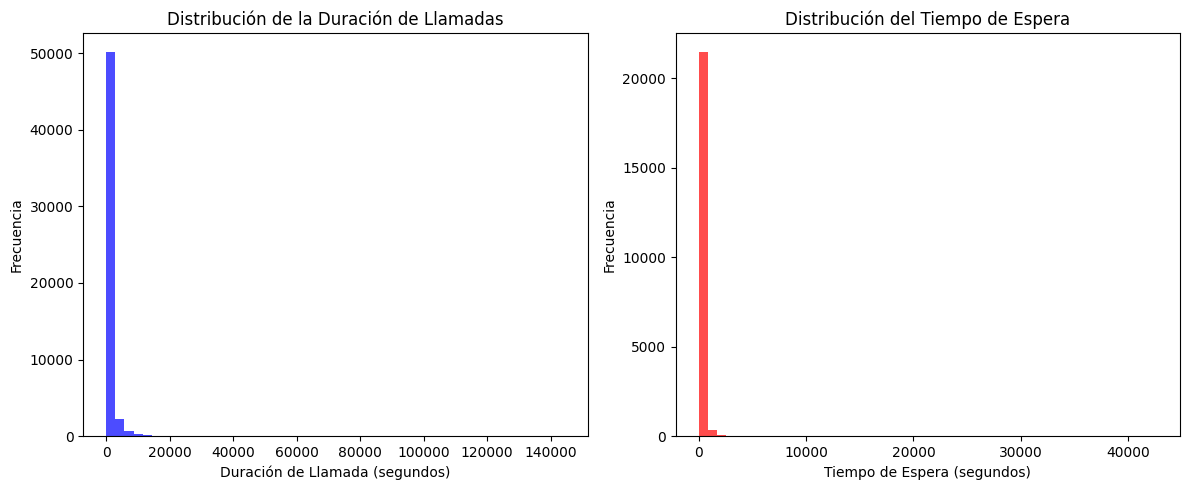

In [359]:
plt.figure(figsize=(12, 5))

# Histograma de duración de llamada
plt.subplot(1, 2, 1)
plt.hist(calls["call_duration"], bins=50, color="blue", alpha=0.7)
plt.xlabel("Duración de Llamada (segundos)")
plt.ylabel("Frecuencia")
plt.title("Distribución de la Duración de Llamadas")

# Histograma de tiempo de espera
plt.subplot(1, 2, 2)
plt.hist(calls["waiting_time"].dropna(), bins=50, color="red", alpha=0.7)
plt.xlabel("Tiempo de Espera (segundos)")
plt.ylabel("Frecuencia")
plt.title("Distribución del Tiempo de Espera")

plt.tight_layout()
plt.show()

Por lo que podemos apreciar en los histogramas hay una enorme concentración de valores en la parte baja del eje x, lo que puede indicar que la gran mayoría de las llamadas son de duración corta y que los tiempos de espera tambien son bastante bajos. Sin embargo, hay valores extremos  con duraciones de llamada y tiempos de espera anormalmente altos. Esto podría indicar problemas en la medición o en la calidad del servicio.

Revisaremos estos valores mediante boxplot:


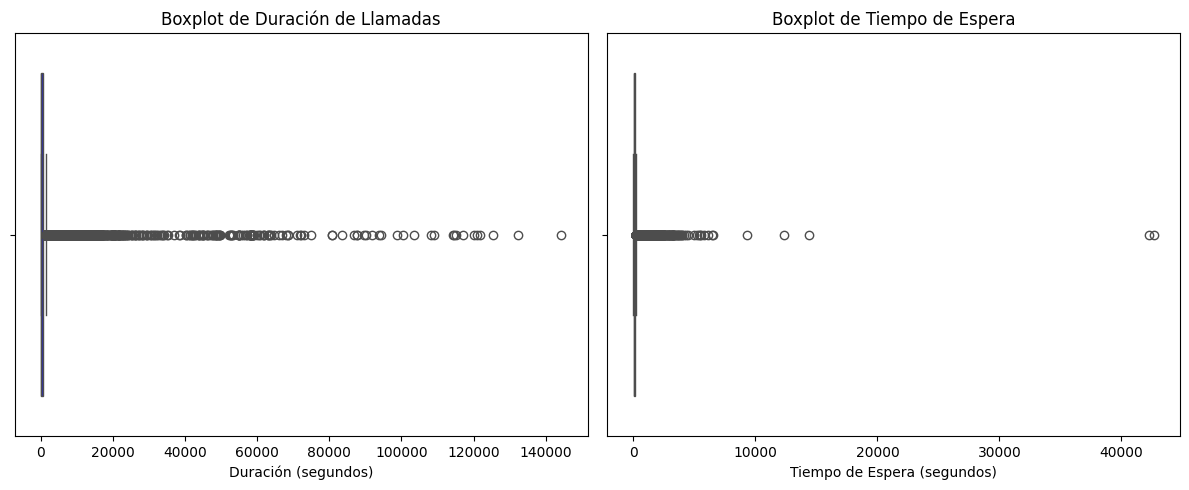

In [360]:
plt.figure(figsize=(12, 5))

# Boxplot de duración de llamadas
plt.subplot(1, 2, 1)
sns.boxplot(x=calls["call_duration"], color="blue")
plt.title("Boxplot de Duración de Llamadas")
plt.xlabel("Duración (segundos)")

# Boxplot de tiempo de espera (solo llamadas entrantes)
plt.subplot(1, 2, 2)
sns.boxplot(x=calls["waiting_time"], color="red")
plt.title("Boxplot de Tiempo de Espera")
plt.xlabel("Tiempo de Espera (segundos)")

plt.tight_layout()
plt.show()

La mayoría de las llamadas tienen una duración baja, pero hay registros con duraciones excesivamente altas, algunas incluso superiores a 140,000 segundos (casi 39 horas).
Esto puede deberse a errores en la captura de datos o llamadas no colgadas correctamente. 

Por otro lado, en el caso de los tiempos de espera existen esperas muy largas, con valores que superan los 40,000 segundos (más de 11 horas).Esto podría indicar llamadas en cola por mucho tiempo o errores en la medición.

Vamos a aplicar el método del rango intercuartil (IQR) para identificar y filtrar los valores atípicos en la duración de llamadas y el tiempo de espera.

In [361]:
# Función para filtrar outliers usando el método IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Aplicamos el filtro a las columnas de interés
calls_filtered = remove_outliers_iqr(calls, "call_duration")
calls_filtered = remove_outliers_iqr(calls_filtered, "waiting_time")

# Verificamos la reducción de outliers
calls_filtered.describe()[["call_duration", "waiting_time"]]

,call_duration,waiting_time
count,17776.000000,17776.000000
mean,187.324089,40.164323
std,299.903095,39.290536
min,0.000000,0.000000
25%,0.000000,11.000000
50%,37.000000,27.000000
75%,248.000000,57.000000
max,1430.000000,175.000000


El valor máximo de duración de llamada se redujo significativamente de más de 140,000 segundos (~39 horas) a 1,430 segundos (~24 minutos). El tiempo de espera máximo también bajó de más de 40,000 segundos (~11 horas) a 175 segundos (~3 minutos).

Esto confirma que los valores atípicos han sido eliminados correctamente.

**- *Gráfico Circular: Llamadas Internas vs. Externas***

Con esto podremos visualizar de mejor manera el porcentaje de llamadas internas y exernas:

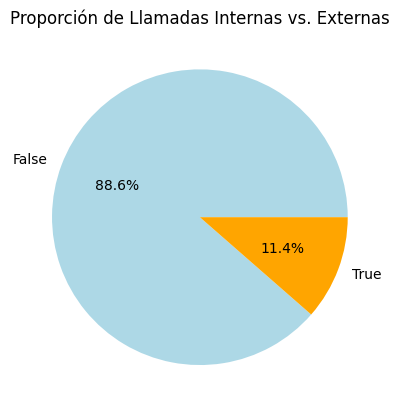

In [362]:
calls["internal"].value_counts().plot(kind="pie", autopct="%1.1f%%", colors=["lightblue", "orange"])
plt.ylabel("")
plt.title("Proporción de Llamadas Internas vs. Externas")
plt.show()


Observamos que  88.6% de las llamadas son externas (interacciones con clientes) y solo un 11.4% son internas (comunicaciones dentro de la empresa), lo que sugiere que la mayoría del tráfico de llamadas está relacionado con la atención al cliente. Esto refuerza la importancia de evaluar la eficiencia de los operadores en este contexto.

**- *Segmentación de Operadores por Eficiencia***

Se van a dividir los operadores en 3 grupos:

- Eficientes

- Promedio

- Ineficientes

Vamos a ver su eficiencia según las métricas de llamadas perdidas, el tiempo de espera y el nímero de llamadas salientes.

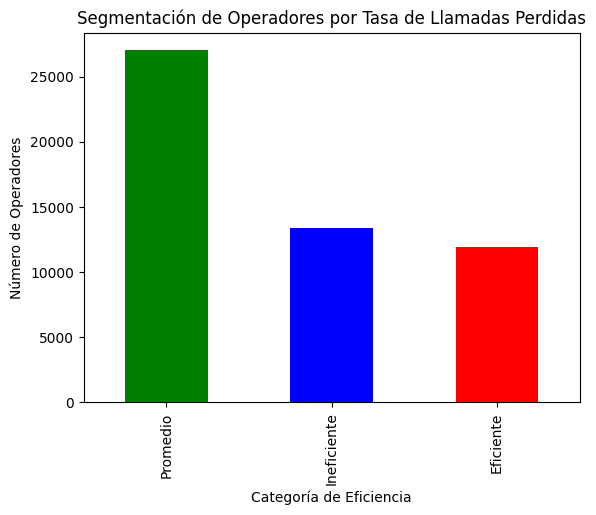

In [363]:
# Eficiencia en la métrica de llamadas perdidas
q25 = calls["missed_call_rate"].quantile(0.25)
q75 = calls["missed_call_rate"].quantile(0.75)

calls["efficiency_category"] = pd.cut(
    calls["missed_call_rate"],
    bins=[0, q25, q75, 1],
    labels=["Eficiente", "Promedio", "Ineficiente"]
)

calls["efficiency_category"].value_counts().plot(kind="bar", color=["green", "blue", "red"])
plt.xlabel("Categoría de Eficiencia")
plt.ylabel("Número de Operadores")
plt.title("Segmentación de Operadores por Tasa de Llamadas Perdidas")
plt.show()


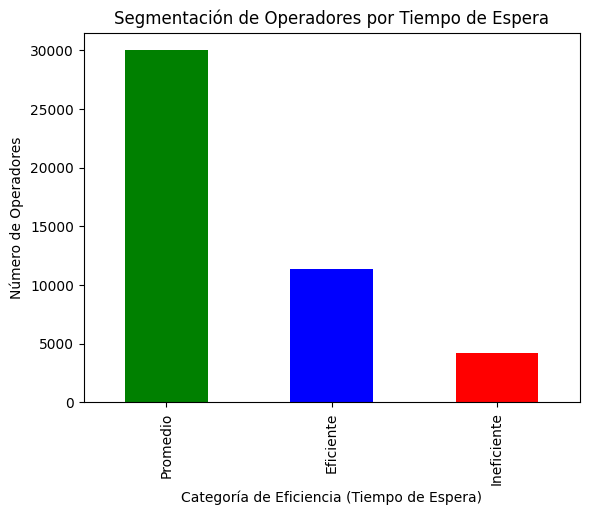

In [364]:
# Eficiencia en la métrica del tiempo de espera
q25_waiting = calls["avg_waiting_time"].quantile(0.25)
q75_waiting = calls["avg_waiting_time"].quantile(0.75)

# Crear categorías de eficiencia por tiempo de espera
calls["efficiency_category_waiting"] = pd.cut(
    calls["avg_waiting_time"],
    bins=[0, q25_waiting, q75_waiting, float('inf')],
    labels=["Eficiente", "Promedio", "Ineficiente"]
)

# Graficar la distribución de operadores por tiempo de espera
calls["efficiency_category_waiting"].value_counts().plot(kind="bar", color=["green", "blue", "red"])
plt.xlabel("Categoría de Eficiencia (Tiempo de Espera)")
plt.ylabel("Número de Operadores")
plt.title("Segmentación de Operadores por Tiempo de Espera")
plt.show()


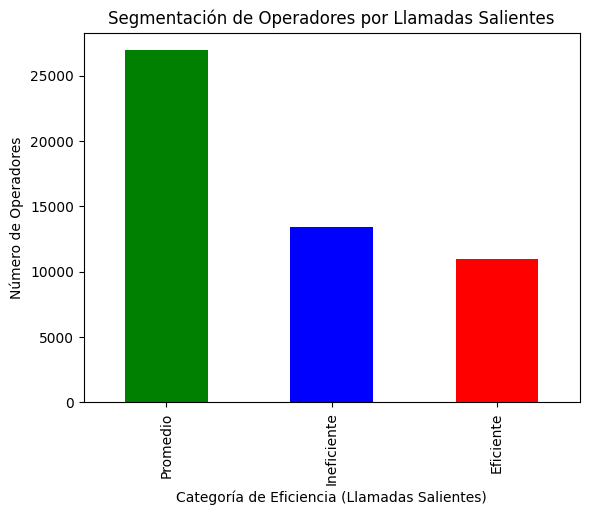

In [365]:
# Eficiencia en el número de llamadas salientes
q25_outgoing = calls["total_outgoing_calls"].quantile(0.25)
q75_outgoing = calls["total_outgoing_calls"].quantile(0.75)

# Crear categorías de eficiencia por llamadas salientes
calls["efficiency_category_outgoing"] = pd.cut(
    calls["total_outgoing_calls"],
    bins=[0, q25_outgoing, q75_outgoing, float('inf')],
    labels=["Eficiente", "Promedio", "Ineficiente"]
)

# Graficar la distribución de operadores por llamadas salientes
calls["efficiency_category_outgoing"].value_counts().plot(kind="bar", color=["green", "blue", "red"])
plt.xlabel("Categoría de Eficiencia (Llamadas Salientes)")
plt.ylabel("Número de Operadores")
plt.title("Segmentación de Operadores por Llamadas Salientes")
plt.show()


En estas segmentaciones un poco mas "básicas" de los operadores podemos ver como un gran número cae dentro de operador promedio, sin embargo veremos mas adelante si esto se modifica mucho a la hora de considerar todas las condiciones para su clasificación.

**Identificación de operadores ineficaces**

**- *Umbrales de ineficiencia***



In [366]:
# Eliminamos valores nulos antes de calcular los umbrales
calls_clean = calls.dropna(subset=["missed_call_rate", "avg_waiting_time", "total_outgoing_calls"])

# Percentiles para umbrales 
q75_missed = calls_clean["missed_call_rate"].quantile(0.75)
q25_missed = calls_clean["missed_call_rate"].quantile(0.25)

q75_waiting = calls_clean["avg_waiting_time"].quantile(0.75)
q25_waiting = calls_clean["avg_waiting_time"].quantile(0.25)

q25_outgoing = calls_clean["total_outgoing_calls"].quantile(0.25)

print(f"Umbral 75% Tasa de Llamadas Perdidas: {q75_missed}")
print(f"Umbral 75% Tiempo de Espera: {q75_waiting}")
print(f"Umbral 25% Llamadas Salientes: {q25_outgoing}")


Umbral 75% Tasa de Llamadas Perdidas: 0.4424778761061947
Umbral 75% Tiempo de Espera: 171.23858504766685
Umbral 25% Llamadas Salientes: 174.0



**- *Clasificación de operadores según rendimiento***

Si un operador tiene alta tasa de llamadas perdidas, alto tiempo de espera o pocas llamadas salientes, será clasificado como ineficiente. Para obtener resultados mas realistas se opto por no ser tan estrictos para clasificar a alguien como Eficiente y basta con cumplir al menos 2 de 3 condiciones.


In [367]:
# Función de clasificación con flexibilidad para "Eficiente"
def classify_operator(row):
    efficient_conditions = sum([
        row["missed_call_rate"] < q25_missed,   # Baja tasa de llamadas perdidas
        row["avg_waiting_time"] < q25_waiting,  # Bajo tiempo de espera
        row["total_outgoing_calls"] > q25_outgoing  # Alto número de llamadas salientes
    ])
    
    # Ineficiente si falla en al menos una de estas condiciones
    if row["missed_call_rate"] > q75_missed or row["avg_waiting_time"] > q75_waiting or row["total_outgoing_calls"] < q25_outgoing:
        return "Ineficiente"
    elif efficient_conditions >= 2:  # Si cumple al menos 2 de 3 condiciones, es eficiente
        return "Eficiente"
    else:
        return "Promedio"

# Aplicamos la clasificación
calls["operator_category"] = calls.apply(classify_operator, axis=1)

# Mostramos la distribución de operadores
print(calls["operator_category"].value_counts())

operator_category
Ineficiente    32199
Promedio       13202
Eficiente       8501
Name: count, dtype: int64


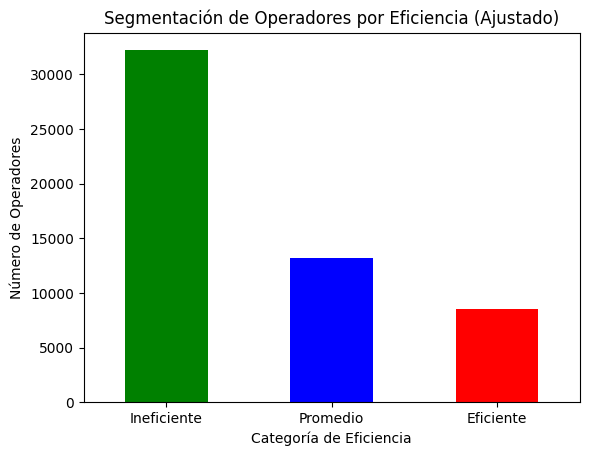

In [368]:
calls["operator_category"].value_counts().plot(kind="bar", color=["green", "blue", "red"])
plt.xlabel("Categoría de Eficiencia")
plt.ylabel("Número de Operadores")
plt.title("Segmentación de Operadores por Eficiencia (Ajustado)")
plt.xticks(rotation=0)
plt.show()


A pesár de que la distribución esta mas equilibrada gracias a la flexibilidad que le dimos a la segmentación, vemos que 32,199 operadores (58%) son ineficientes lo que indica que más de la mitad de los operadores presentan problemas en al menos uno de los criterios clave. Por otro lado, solo vemos a 8,501 operadores (15%) como eficientes, lo cuál contrasta bastante con las graficas anteriores. Finalmente tenemos que 13,202 operadores (24%) están en el rango promedio, lo que significa que no destacan ni por ser especialmente malos ni por ser altamente eficientes.


**- *Rankings de operadores***

Ahora construiremos un ranking de los 10 mejores operadores, ordenándolos en función de su desempeño:

In [369]:
# Creamos una copia para el ranking
calls_ranked = calls.copy()

# Asignamos valores numéricos para el ranking (1 = mejor, 3 = peor)
category_order = {"Eficiente": 1, "Promedio": 2, "Ineficiente": 3}
calls_ranked["category_rank"] = calls_ranked["operator_category"].map(category_order)

# Ordenamos por categoría, llamadas salientes (desc), y tasa de llamadas perdidas (asc)
calls_ranked = calls_ranked.sort_values(by=["category_rank", "total_outgoing_calls", "missed_call_rate"],
                                        ascending=[True, False, True])

# Eliminamos duplicados de operator_id, manteniendo solo el mejor registro
calls_ranked = calls_ranked.drop_duplicates(subset=["operator_id"], keep="first")

# Agregamos una columna de ranking general después de eliminar duplicados
calls_ranked["ranking"] = range(1, len(calls_ranked) + 1)

# Mostramos los primeros 10 operadores únicos en el ranking
calls_ranked[["operator_id", "operator_category", "total_outgoing_calls", "missed_call_rate", "ranking"]].head(10)


,operator_id,operator_category,total_outgoing_calls,missed_call_rate,ranking
1763,879898.0,Eficiente,7856,0.398406,1
14,880028.0,Eficiente,2836,0.402655,2
39292,926486.0,Eficiente,2610,0.438596,3
3702,883942.0,Eficiente,2228,0.394118,4
32872,915556.0,Eficiente,2225,0.352381,5
47172,937860.0,Eficiente,1531,0.288889,6
10773,932500.0,Eficiente,1189,0.423077,7
27154,905844.0,Eficiente,1128,0.426471,8
1765,879896.0,Eficiente,1071,0.390625,9
10212,900892.0,Eficiente,1023,0.321839,10


In [370]:
# Mostramos los ultimos operadores únicos en el ranking
calls_ranked[["operator_id", "operator_category", "total_outgoing_calls", "missed_call_rate", "ranking"]].tail(10)

,operator_id,operator_category,total_outgoing_calls,missed_call_rate,ranking
2846,934076.0,Ineficiente,0,0.142857,1084
47886,948286.0,Ineficiente,0,0.142857,1085
14545,894614.0,Ineficiente,0,0.166667,1086
22157,911142.0,Ineficiente,0,0.166667,1087
33966,924936.0,Ineficiente,0,0.166667,1088
14444,910226.0,Ineficiente,0,0.250000,1089
14503,930242.0,Ineficiente,0,0.250000,1090
14474,919896.0,Ineficiente,0,0.285714,1091
43623,934098.0,Ineficiente,0,0.400000,1092
14454,913886.0,Ineficiente,0,0.500000,1093


Que tengamos una mayoría de operadores ineficientes sugiere que el sistema tiene margen de mejora y es necesario tomar acciones sobre los operadores ineficientes para mejorar la calidad del servicio.


**Evaluación de hipótesis estadísticas**

Las hipótesis que queremos poner a prueba son las siguientes:

- Los operadores con un alto porcentaje de llamadas perdidas son menos eficaces.
    
- Los operadores con tiempos de espera prolongados en llamadas entrantes afectan la calidad del servicio.
    
- Los operadores asignados a llamadas salientes que hacen menos llamadas de lo esperado podrían ser menos eficaces.


**- *Comparación de grupos de operadores.***

Mediante la comparacion buscaremos identificar posibles tendencias o diferencias entre los grupos.

In [371]:
# Estadísticas descriptivas por categoría de operador
metrics = ["missed_call_rate", "avg_waiting_time", "total_outgoing_calls"]
descriptive_stats = calls.groupby("operator_category")[metrics].describe()
print(descriptive_stats)

                  missed_call_rate                                          \
                             count      mean       std       min       25%   
operator_category                                                            
Eficiente                   8501.0  0.318786  0.076070  0.000000  0.257353   
Ineficiente                32199.0  0.501537  0.319995  0.000000  0.274510   
Promedio                   13202.0  0.356688  0.037317  0.293578  0.329787   

                                                avg_waiting_time              \
                        50%       75%       max            count        mean   
operator_category                                                              
Eficiente          0.323232  0.390625  0.442478           8282.0   31.039075   
Ineficiente        0.454874  0.985071  1.000000          25206.0  135.837734   
Promedio           0.346535  0.381944  0.439024          12090.0   77.588987   

                   ...                          to

C:\Users\Mares\AppData\Local\Temp\ipykernel_4560\40782396.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="operator_category", y=metric, data=calls, palette="Set2")
C:\Users\Mares\AppData\Local\Temp\ipykernel_4560\40782396.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="operator_category", y=metric, data=calls, palette="Set2")
C:\Users\Mares\AppData\Local\Temp\ipykernel_4560\40782396.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="operator_category", y=metric, data=calls, palette="Set2")


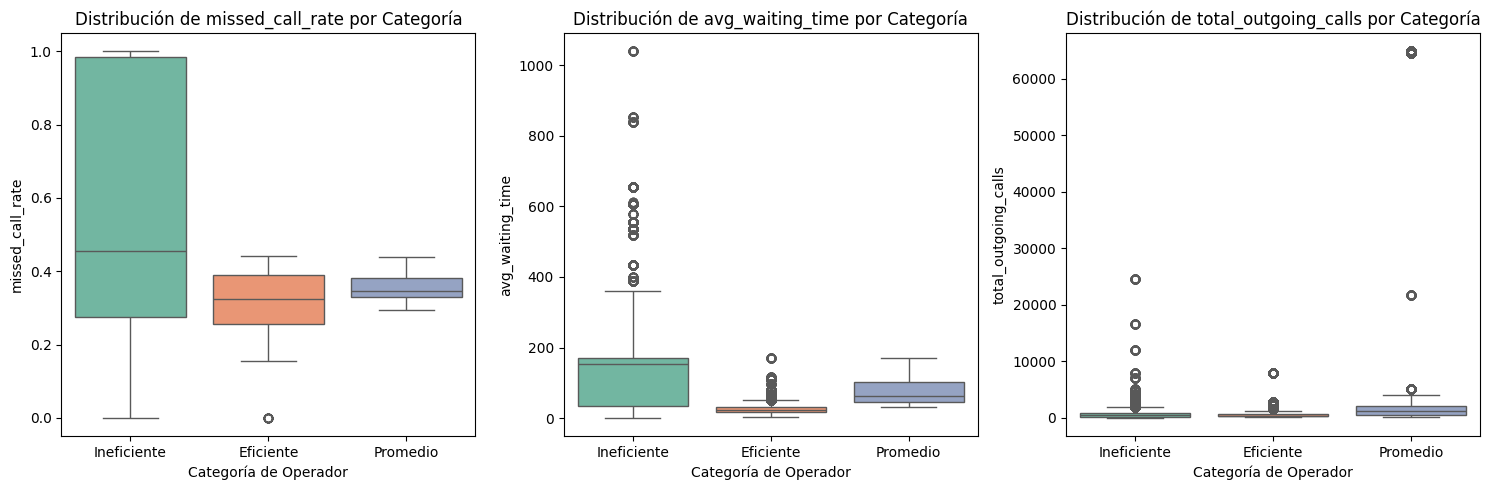

In [372]:
# Visualización de las distribuciones por categoría
plt.figure(figsize=(15, 5))
for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x="operator_category", y=metric, data=calls, palette="Set2")
    plt.title(f"Distribución de {metric} por Categoría")
    plt.xlabel("Categoría de Operador")
    plt.ylabel(metric)
plt.tight_layout()
plt.show()

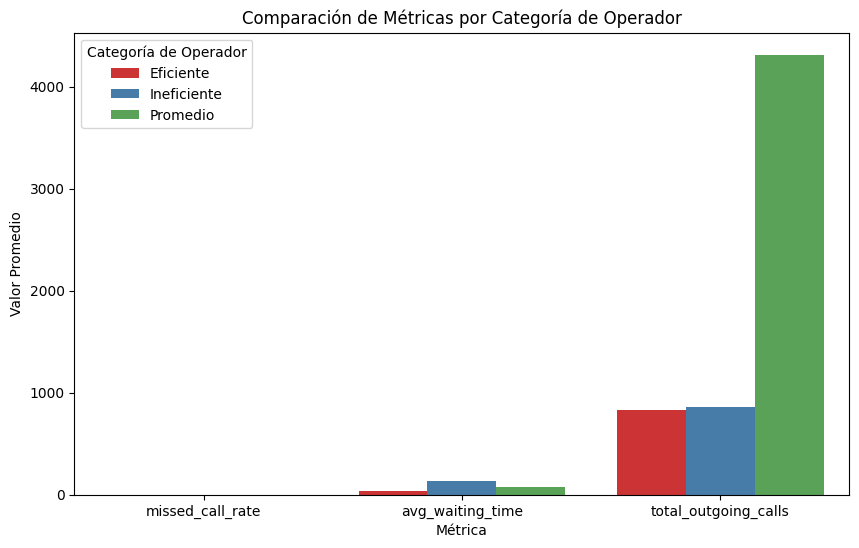

In [373]:
# Gráficos de barras con promedios por categoría
calls_grouped = calls.groupby("operator_category")[metrics].mean().reset_index()
calls_grouped = calls_grouped.melt(id_vars="operator_category", var_name="Métrica", value_name="Valor Promedio")
plt.figure(figsize=(10, 6))
sns.barplot(x="Métrica", y="Valor Promedio", hue="operator_category", data=calls_grouped, palette="Set1")
plt.title("Comparación de Métricas por Categoría de Operador")
plt.xlabel("Métrica")
plt.ylabel("Valor Promedio")
plt.legend(title="Categoría de Operador")
plt.show()

Los operadores ineficientes muestran la tasa más alta de llamadas perdidas y los tiempos de espera más largos, lo que indica problemas significativos en su capacidad de respuesta. Por otro lado, los operadores eficientes destacan por su baja tasa de llamadas perdidas y tiempos de espera cortos, como era de esperarse. La categoría de operadores promedio, aunque maneja un alto volumen de llamadas salientes, no necesariamente se traduce en eficiencia, ya que sus tiempos de espera son considerablemente mayores a los de los operadores eficientes. 

**- *Pruebas estadísticas***


**1. Los operadores con un alto porcentaje de llamadas perdidas son menos eficaces**



H₀ (nula): No hay diferencia en la tasa de llamadas perdidas entre grupos.

H₁ (alternativa): Hay diferencias significativas entre al menos dos grupos.

Para esto utilizaremos la prueba ANOVA verificando la normalidad de las tasas de llamadas perdidas para cada grupo usando una prueba de Shapiro-Wilk. Tambien usaremos la prueba de Levene para asegurarnos de que las varianzas sean iguales entre los grupos. 



In [374]:
# Verificación de normalidad (Shapiro-Wilk)
normality_results = calls.groupby('operator_category')['missed_call_rate'].apply(shapiro)

# Verificación de homogeneidad de varianzas (Levene)
levene_test = levene(
    calls[calls['operator_category'] == 'Eficiente']['missed_call_rate'],
    calls[calls['operator_category'] == 'Ineficiente']['missed_call_rate'],
    calls[calls['operator_category'] == 'Promedio']['missed_call_rate']
)

print(normality_results)
print(levene_test)

operator_category
Eficiente      (0.9652683174081723, 5.302670808860337e-41)
Ineficiente    (0.8821732839458614, 4.262738697309602e-91)
Promedio       (0.9567335738200808, 5.247687848812389e-52)
Name: missed_call_rate, dtype: object
LeveneResult(statistic=np.float64(11529.61356207336), pvalue=np.float64(0.0))


c:\Users\Mares\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8501.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Mares\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 32199.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Mares\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 13202.
  res = hypotest_fun_out(*samples, **kwds)


Al tener valores p muy bajos en los 3 grupos podemos deducir que no hay normalidad. Lo mismo en cuanto a la homogeneidad de varianzas lo que significa que en este caso lo recomendable sera usar la prueba Kruskal-Wallis.

In [375]:
# Realizamos la prueba Kruskal-Wallis
kruskal_result = kruskal(
    calls[calls['operator_category'] == 'Eficiente']['missed_call_rate'],
    calls[calls['operator_category'] == 'Ineficiente']['missed_call_rate'],
    calls[calls['operator_category'] == 'Promedio']['missed_call_rate']
)

print(kruskal_result)

KruskalResult(statistic=np.float64(4354.080805356087), pvalue=np.float64(0.0))


Teniendo un valor p de 0.0, rechazamos la hipótesis nula. Esto significa que sí hay diferencias significativas en la tasa de llamadas perdidas entre al menos dos de los grupos de operadores.

**2. Los operadores con tiempos de espera prolongados en llamadas entrantes afectan la calidad del servicio**


H₀: No hay diferencia en los tiempos de espera entre los grupos de eficiencia.

H₁: Al menos un grupo tiene un tiempo de espera significativamente diferente.

In [376]:
# Eliminar valores nulos en la columna 'avg_waiting_time' antes de realizar la prueba
calls_cleaned = calls.dropna(subset=['avg_waiting_time'])

# Realizar prueba Kruskal-Wallis sobre los tiempos de espera
kruskal_result_waiting_time = kruskal(
    calls_cleaned[calls_cleaned['operator_category'] == 'Eficiente']['avg_waiting_time'],
    calls_cleaned[calls_cleaned['operator_category'] == 'Ineficiente']['avg_waiting_time'],
    calls_cleaned[calls_cleaned['operator_category'] == 'Promedio']['avg_waiting_time']
)

print(kruskal_result_waiting_time)


KruskalResult(statistic=np.float64(10404.228423221004), pvalue=np.float64(0.0))


Dado que nuevamente el valor de p es mucho menor que el umbral común de 0.05, podemos rechazar la hipótesis nula y concluir que existen diferencias significativas en los tiempos de espera entre los grupos de operadores. Esto sugiere que los operadores con tiempos de espera más largos podrían afectar la calidad del servicio, como se esperaba en la hipótesis.

**3. Los operadores asignados a llamadas salientes que hacen menos llamadas de lo esperado podrían ser menos eficaces**


H₀: No hay diferencia en el número de llamadas salientes entre los grupos.

H₁: Al menos un grupo muestra diferencias significativas.

In [377]:
# Prueba de Kruskal-Wallis para las llamadas salientes
kruskal_outgoing_result = kruskal(
    calls[calls['operator_category'] == 'Eficiente']['total_outgoing_calls'],
    calls[calls['operator_category'] == 'Ineficiente']['total_outgoing_calls'],
    calls[calls['operator_category'] == 'Promedio']['total_outgoing_calls']
)

print(kruskal_outgoing_result)


KruskalResult(statistic=np.float64(6593.125110718146), pvalue=np.float64(0.0))


De nuevo rechazamos la hipótesis nula y concluimos que hay diferencias significativas en el número de llamadas salientes entre los grupos de eficiencia (Eficiente, Ineficiente y Promedio). 



**Conclusiones generales**

El análisis muestra que los operadores eficientes tienen una baja tasa de llamadas perdidas, tiempos de espera cortos y un número adecuado de llamadas salientes, lo que contribuye a una mayor calidad en el servicio. En cambio, los operadores ineficientes presentan una tasa más alta de llamadas perdidas, tiempos de espera prolongados y un bajo volumen de llamadas salientes, lo que impacta negativamente en su desempeño. Los operadores en la categoría promedio, aunque manejan un gran volumen de llamadas salientes, también presentan tiempos de espera relativamente largos. Las pruebas confirmaron las tres hipótesis planteadas, demostrando que los operadores con una alta tasa de llamadas perdidas, tiempos de espera largos y bajo volumen de llamadas salientes son menos eficaces.

Las mejor será una mejora en la capacitación de los operadores, enfocándose en la gestión de llamadas perdidas, reducción de tiempos de espera y manejo eficiente de las llamadas salientes. Además, sería bastante útil revisar los protocolos actuales para minimizar las llamadas perdidas y explorar la automatización de algunos procesos. También se recomienda optimizar la asignación de operadores a llamadas entrantes para reducir los tiempos de espera y asegurar que los operadores de llamadas salientes realicen el número adecuado de interacciones. 

Implementar un sistema de retroalimentación constante y desarrollar paneles de control permitiría monitorear el rendimiento en tiempo real. Finalmente, se podrían aplicar técnicas de segmentación avanzada y análisis predictivos para identificar a los operadores con mayor probabilidad de ser ineficientes y tomar medidas preventivas.